<a href="https://colab.research.google.com/github/shehlarafiq5/ML-algorithms/blob/main/GAN's_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision tensorflow matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Keras to load MNIST dataset
from tensorflow.keras.datasets import mnist


In [3]:
# Load MNIST data from Keras
(x_train, y_train), (_, _) = mnist.load_data()

# Normalize the images to the range [-1, 1]
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=1)  # Expand dims to fit the (N, 1, 28, 28) shape required for PyTorch

# Convert numpy arrays to PyTorch tensors
x_train = torch.tensor(x_train)

# Create a DataLoader for the training data
train_loader = torch.utils.data.DataLoader(x_train, batch_size=128, shuffle=True)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()  # Output between -1 and 1
        )

    def forward(self, x):
        return self.model(x).view(-1, 1, 28, 28)


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.model(x)


In [6]:
generator = Generator()
discriminator = Discriminator()

# Loss function and optimizers
criterion = nn.BCELoss()
lr = 0.0002
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator.to(device)
discriminator.to(device)


Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [7]:
num_epochs = 20
latent_size = 100

for epoch in range(num_epochs):
    for i, real_images in enumerate(train_loader):
        real_images = real_images.to(device)

        # Labels for real and fake data
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Generate fake images
        z = torch.randn(real_images.size(0), latent_size).to(device)
        fake_images = generator(z)

        # Compute loss for fake images
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # -----------------
        #  Train Generator
        # -----------------
        z = torch.randn(real_images.size(0), latent_size).to(device)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.4f}, D(G(z)): {fake_score.mean().item():.4f}')


Epoch [1/20], Step [200/469], D Loss: 0.1747, G Loss: 2.7139, D(x): 0.9997, D(G(z)): 0.1580
Epoch [1/20], Step [400/469], D Loss: 0.0325, G Loss: 8.8980, D(x): 0.9786, D(G(z)): 0.0082
Epoch [2/20], Step [200/469], D Loss: 1.9808, G Loss: 0.6881, D(x): 0.4079, D(G(z)): 0.5699
Epoch [2/20], Step [400/469], D Loss: 0.8430, G Loss: 1.0384, D(x): 0.7125, D(G(z)): 0.3741
Epoch [3/20], Step [200/469], D Loss: 0.3376, G Loss: 2.8241, D(x): 0.8394, D(G(z)): 0.1287
Epoch [3/20], Step [400/469], D Loss: 2.1932, G Loss: 1.6554, D(x): 0.5398, D(G(z)): 0.5666
Epoch [4/20], Step [200/469], D Loss: 0.8570, G Loss: 1.9699, D(x): 0.7349, D(G(z)): 0.3185
Epoch [4/20], Step [400/469], D Loss: 0.3777, G Loss: 4.0646, D(x): 0.8458, D(G(z)): 0.1295
Epoch [5/20], Step [200/469], D Loss: 0.4657, G Loss: 2.2371, D(x): 0.9495, D(G(z)): 0.2365
Epoch [5/20], Step [400/469], D Loss: 1.0644, G Loss: 2.2949, D(x): 0.8411, D(G(z)): 0.2570
Epoch [6/20], Step [200/469], D Loss: 0.1944, G Loss: 3.1916, D(x): 0.9443, D(G(

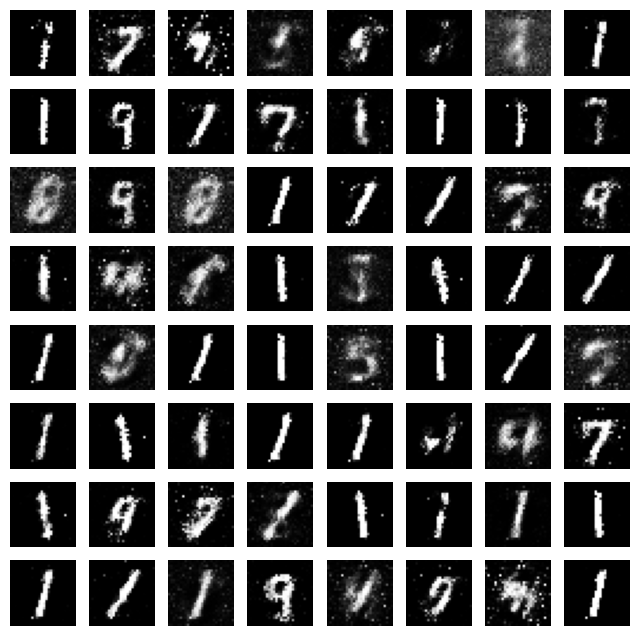

In [8]:
def denorm(x):
    return (x + 1) / 2

def show_generated_images(generator):
    z = torch.randn(64, latent_size).to(device)
    fake_images = generator(z)
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    fake_images = denorm(fake_images.cpu().detach())

    plt.figure(figsize=(8, 8))
    for i in range(fake_images.size(0)):
        plt.subplot(8, 8, i+1)
        plt.imshow(fake_images[i][0], cmap='gray')
        plt.axis('off')
    plt.show()

# Show some generated images
show_generated_images(generator)


In [9]:
# Save the generator model
torch.save(generator.state_dict(), 'generator.pth')

# Save the discriminator model
torch.save(discriminator.state_dict(), 'discriminator.pth')


In [15]:
batch_size = 64  # Number of images in each batch
# Get a batch of real images from the MNIST dataset (without labels)
real_images = next(iter(train_loader)).to(device)

# Generate a batch of fake images using the generator
z = torch.randn(batch_size, latent_size).to(device)
fake_images = generator(z)

# Pass them through the discriminator
fake_outputs = discriminator(fake_images.detach())
print("Discriminator output for fake images:", fake_outputs.mean().item())


Discriminator output for fake images: 0.062269821763038635


In [21]:
real_images = next(iter(train_loader))
real_images = real_images.to(device)
# print(real_images)

In [20]:
# Get a batch of real images from the MNIST dataset
real_images = next(iter(train_loader))
real_images = real_images[0].to(device)  # Get the images tensor

# Pass them through the discriminator
real_outputs = discriminator(real_images)
print("Discriminator output for real images:", real_outputs.mean().item())


Discriminator output for real images: 0.9999908208847046


In [16]:
# Generate a batch of fake images using the generator
z = torch.randn(batch_size, latent_size).to(device)
fake_images = generator(z)

# Pass them through the discriminator
fake_outputs = discriminator(fake_images.detach())
print("Discriminator output for fake images:", fake_outputs.mean().item())

Discriminator output for fake images: 0.0804615169763565
